# Explicit scheme - with implicit solver


## Definitions


In [1]:
import openmesh as om
import numpy as np
import matplotlib.pyplot as plt

# mesh = om.read_trimesh('T40.off')
# mesh = om.read_trimesh('T16.off')
# mesh = om.read_trimesh('T8.off')
mesh = om.read_trimesh('T4.off')

V=mesh.points()
X=V[:,0]
Y=V[:,1]

def initActiveNodes():
    ActiveNodeList = []
    for vh in mesh.vertices():
        k = vh.idx()
        if V[k,0] == 0 or V[k,1] == 1:
            ActiveNodeList.append(vh)
    return ActiveNodeList

def initActiveFaceList():
    ActiveFaceList = []

    i=0
    for fh in mesh.faces():
        counter = 0
    
        for vh in mesh.fv(fh):
            if vh in ActiveNodeList:
                # print(vh.idx(),' in ', fh.idx())                
                counter = counter + 1
            
        if counter == 2:
            ActiveFaceList.append(fh)

    return ActiveFaceList

def init_TS_nodes():
    T = np.zeros(len(V))+7
    S = np.zeros(len(V))+7

    for vh in ActiveNodeList:    
        k = vh.idx()
        if V[k,0] == 0:
            T[k] = 0
            S[k] = 0
        elif V[k,1] == 1:
            T[k] = V[k,0]
            S[k] = V[k,0]            
            # S[k] = 0
    
    return T, S

def init_TS_faces():
    Tf = np.zeros(len(mesh.faces()))+7
    Sf = np.zeros(len(mesh.faces()))+7

    for fh in ActiveFaceList:
        T_ABC = 0
        S_ABC = 0
        counter = 0
        for vh in mesh.fv(fh):
            if vh in ActiveNodeList:
                T_ABC = T_ABC + T[vh.idx()]
                S_ABC = S_ABC + S[vh.idx()]            
                counter = counter + 1
            
        if counter != 2:
            print('ERR at face', fh.idx())
        else:
            Tf[fh.idx()] = T_ABC / 2
            Sf[fh.idx()] = S_ABC / 2
            
    return Tf, Sf
    
# routine to get active face indices    
def getActiveFaceIndices():
    I_list = []
    for fh in ActiveFaceList:
        I_list.append(fh.idx())
        
    return I_list

    
def getActiveNodeIndices():
    I_list = []
    for fh in ActiveNodeList:
        I_list.append(fh.idx())

    return I_list


def getProcessedFaceIndices():
    I_list = []
    for fh in ProcessedFaceList:
        I_list.append(fh.idx())
        
    return I_list

def getObsoleteFaceIndices():
    I_list = []
    for fh in ObsoleteFaceList:
        I_list.append(fh.idx())
        
    return I_list

def get_T_C_dummy(T_A, T_B):
    return (T_A + T_B)/2 + 10

# ... update faces: done inline    

def getAngle(v1, v2):
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))    
    return angle

def getGrad2(I, U):
    m = np.zeros((2, 2))
    b = np.zeros((2, 1))

    for k in range(2):
        m[k,0] = V[I[k+1],0]-V[I[0],0]
        m[k,1] = V[I[k+1],1]-V[I[0],1]
        b[k] = U[k+1]-U[0]
                
    g = np.linalg.solve(m, b)    
    c = np.linalg.cond(m)

    return c, g

def any():
    global global_I
    print('(any)',global_I)
    
def test():
    print(S)
    print(T)    


ActiveNodeList = initActiveNodes()
ActiveFaceList = initActiveFaceList()
    
T, S = init_TS_nodes()
Tf, Sf = init_TS_faces()

I_active_faces = getActiveFaceIndices()
print('active faces:', I_active_faces)



active faces: [1, 4, 5, 8, 11, 22, 40, 74, 75]


Defining the residual and the cost function.

In [2]:
def residual(u):
    global global_I
    
    I = global_I
    #
    # print('(residual)', I)
    #
    # TC = u[0]
    # SC = u[1]    
    
    T[I[2]]=u[0]
    S[I[2]]=u[1]
    
    # print('(res) I', I)
    
    m = np.zeros((2, 2))
    b = np.zeros((2, 1))

    for k in range(2):
        m[k,0] = V[I[k],0]-V[I[2],0]
        m[k,1] = V[I[k],1]-V[I[2],1]
        b[k] = T[I[k]]-T[I[2]]
        # b[k] = T[I[k]]-TC
    g = np.linalg.solve(m, b)
    
    gnorm = np.linalg.norm(g)
    Ybar=sum(V[I,1])/3
    Sbar=sum(S[I])/3
    # rT = gnorm - Ybar / (Sbar + 1e-7)
    rT = gnorm - Sbar / (Ybar + 1e-7)
    
    # print('g:', g, '\n Ybar:', Ybar, '\n Sbar:', Sbar, '\n rT:', rT, '\n\n\n')    
    # proceed with the calculation of rS
    m=np.argmin(S[I[0:2]])
    Vm=V[I[m],0:2]
    Vc=V[I[2],0:2]
    
    # print('Vm', Vm, 'Vc', Vc, '\n\n\n')    
    gs = g / (gnorm+1e-9)
    cm = S[I[m]] - np.dot(gs.transpose(), Vm)
    Sm = np.dot(gs.transpose(), Vc) + cm    
    rS = S[I[2]] - Sm
    
    r = [rT, rS[0]]
    
    return r

def cost(U):
    R=residual(U)
    c=np.inner(R,R)
    # print(c)
    return c

global_I = [25, 20, 46]
I=global_I

print('\n T[I] \n',T[I], '\n S[I]: \n', S[I], '\n V[I]: \n', V[I,0:2])

U = np.zeros(2)

U[0]=T[I[2]]
U[1]=S[I[2]]

U[0]=1.0
U[1]=0.4

T[I[2]]=U[0]
S[I[2]]=U[1]

print(U)

r = residual(U)
c = cost(U)
print(U, c, r)


 T[I] 
 [0. 0. 7.] 
 S[I]: 
 [0. 0. 7.] 
 V[I]: 
 [[0.         1.        ]
 [0.         0.80000001]
 [0.5        0.89999998]]
[1.  0.4]
[1.  0.4] 3.4393553397008594 [1.851851867658658, -0.09999999974999996]


In [3]:
import scipy.optimize as opt
import time

I = [25, 20, 46]
# I = [0, 5, 30]
I = [5, 10, 34]
# I = [5, 10, 38]
# I = [30, 0, 1]

global_I = I

t0 = time.time()
res = opt.minimize(cost, U, method='powell', tol=1e-10, options={'maxiter': 200, 'disp': True})
t1 = time.time()

print('\n t1-t0: = %.1f' % float(t1 - t0),'\n res:', res)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 128

 t1-t0: = 0.0 
 res:    direc: array([[ 0.0233274 , -0.0013422 ],
       [ 0.01084553,  0.01904414]])
     fun: 5.639988775268823e-27
 message: 'Optimization terminated successfully.'
    nfev: 128
     nit: 5
  status: 0
 success: True
       x: array([0.27777768, 0.5       ])


In [4]:
print('T[I]:', T[I],'\nS[I]:', S[I])

T[I]: [0.         0.         0.27777768] 
S[I]: [0.  0.  0.5]


In [5]:
import random

global_I = [25, 20, 46]
global_nit = []
global_fun = []
global_nfev = []

def getC(I):
    global global_I    
    # print('(getC)>', global_I, I)
    global_I = I

    U = np.zeros(2)
    U[0]=T[I[2]]
    U[1]=S[I[2]]

    # U[0]=0
    # U[1]=0
    
    j=0
    U[0]=T[I[0]]
    U[1]=S[I[0]]
    
    U[0]=random.uniform(max(0,T[I[0]]-j/4), T[I[0]]+1+j/2)
    U[1]=random.uniform(max(0,S[I[0]]-j/4), S[I[0]]+1+j/2)
    
    while True:
        j=j+1
        
        if j>3:
            print('ERR no convergence - exit. V:', V[I[2],0:2])
            # r0=(T[I[0]]+T[I[1]])/2
            # r1=(S[I[0]]+S[I[1]])/2              
            break
            
        t0 = time.time()
        res = opt.minimize(cost, U, method='powell', tol=1e-10, options={'maxiter': 50, 'disp': False})
        t1 = time.time()
        global_nit.append(res.nit)
        global_fun.append(res.fun)
        global_nfev.append(res.nfev)

        r0=res.x[0]
        r1=res.x[1]
    
        if res.fun > 1e-9:
            # print('ERR no convergence:', res.fun)
            U[0]=random.uniform(max(0,T[I[0]]-j/4), T[I[0]]+1+j/2)
            U[1]=random.uniform(max(0,S[I[0]]-j/4), S[I[0]]+1+j/2)   
        else:
            break
            
            # print(res) 
    # print('(getC)<', global_I, I) 
    
    TC=r0
    SC=r1
    
    return TC, SC

I = [25, 20, 46]
# I = [0, 5, 30]
# I = [5, 10, 34]
# I = [5, 10, 38]
# I = [30, 0, 1]
global_I = I
TC, SC = getC(I)
print(TC,SC)
print('nit:', global_nit, 'fun:', global_fun)

0.09259258221333881 0.4999999972999996
nit: [4] fun: [1.5407439555097887e-32]


In [6]:
for k in range(50):
    TC, SC = getC(I)
    # print(TC,SC)
    # print('nit:', global_nit, 'fun:', global_fun)
    
print(np.array(global_nit).transpose())
sort_global_fun = np.sort(global_fun)
print(sort_global_fun[-11:])
print(TC,SC)


[4 4 4 4 4 4 4 4 4 3 4 3 4 3 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 3 4 3 4 3 4 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[3.85185989e-33 3.85185989e-33 1.54074396e-32 4.93038066e-31
 1.20563215e-30 8.34466926e-28 2.11691132e-27 2.23502860e-27
 4.53616052e-27 1.81260576e-26 9.90605220e-24]
0.09259258221333881 0.4999999972999998


## Running

In [7]:
ProcessedFaceList = []
ObsoleteFaceList = []

ActiveNodeList = initActiveNodes()
ActiveFaceList = initActiveFaceList()

T, S = init_TS_nodes()
Tf, Sf = init_TS_faces()

global global_I
global_I = I

# print('len: list(I[K]) \t \t (id_A, id_B) -> id_C \n \n \n')
j=0
while len(ActiveFaceList)>0:
    j=j+1    
    
    # (0) update the index
    I_active_faces = getActiveFaceIndices()

    I = np.array(I_active_faces)
    K = np.argsort(Tf[I], axis=0)

    # print('(len)', len(I_active_faces),': (f)', list(I[K]))
    
    # (1) obtain id of next face
    next_face_id = (I[K])[0]
    fh = mesh.face_handle(next_face_id)
    
    # quick check whether the face is obsolete,
    # which is a normal situation that should not be handled as an error
    # but by moving on to the next face

    counter = 0
    for vh in mesh.fv(fh):
        if vh in ActiveNodeList:
            counter = counter + 1    
    if counter == 3:
        # print('remove obsolete face:', fh.idx())
        ObsoleteFaceList.append(fh)
        ActiveFaceList.remove(fh)
        continue
            
    # (2) calculate value of outgoing vertex
    counter = 0
    for vh in mesh.fv(fh):
        if vh in ActiveNodeList:
            # print(vh.idx(),'ingoing')
            if counter == 0:
                counter = counter + 1
                id_A = vh.idx()
                T_A = T[vh.idx()] # not needed ?
                S_A = S[vh.idx()]                
            elif counter == 1:
                counter = counter + 1
                id_B = vh.idx()
                T_B = T[vh.idx()]
                S_B = S[vh.idx()]
            else:
                print('ERR: too many ingoing nodes')
                
        else:
            # print(vh.idx(),'outgoing')        
            id_C = vh.idx()
            vh_C = vh

######################################################################################################

    if counter == 2:
        I_ABC = [id_A, id_B, id_C]
        # I = np.array(I)
        global_I = I_ABC

        # T_C_dummy = get_T_C_dummy(T_A, T_B)        
        T_C, S_C = getC(I_ABC)
        
        # print('T', I_ABC,' : %.2f' %T_C)        
        # T_C = T_C_dummy        
        # T_C = T_C + j / 1000
        
        print('(main)', global_I,':', T_C, S_C) # , '\n\n\n')
        # print('T', T[I_ABC], 'S', S[I_ABC])
        # any()
        
        T[id_C] = T_C
        S[id_C] = S_C
        
        # print('T:', T[I_ABC], 'S:', S[I_ABC])
        
    else:
        print('ERR: missing inputs for calculating T_C')
        # T[id_C] = j
        
    # T[id_C] = j
    
    # (3) handle the list of active faces
    if (not vh_C in ActiveNodeList):
        ActiveNodeList.append(vh_C) # also ! 
    else:
        print('node already listed:', vh_C.idx())
    
    ActiveFaceList.remove(fh)
    ProcessedFaceList.append(fh)

    # (3b) agregate new faces to the list
    f_list = []
    # print('(', id_A, ',', id_B, ') ->', id_C,'\t \t',len(I_active_faces),': ', list(I[K]))    
    for fvh in mesh.vf(vh_C):
        f_list.append(fvh.idx())
        # print('fv', fvh.idx())
        if (not fvh in ActiveFaceList) and (not fvh in ProcessedFaceList):
            counter = 0
            for vh in mesh.fv(fvh):
                if vh in ActiveNodeList:
                    counter = counter + 1
        
            if counter == 2:
                ActiveFaceList.append(fvh)
                # print('new face:', fvh.idx())
                
                counter = 0
                for vh in mesh.fv(fvh):
                    if vh in ActiveNodeList:
                        if counter == 0:
                            T_A = T[vh.idx()]
                            counter = counter + 1
                        elif counter == 1:
                            T_B = T[vh.idx()]
                    Tf[fvh.idx()] = (T_A + T_B)/2
            
            elif counter == 3:
                print('face duplicate registered:', fvh.idx())                
    
    # if j>111:
    #    print('debugging...')
    #    break
        
print('\n T: \n', T)
print('\n Tf: \n', Tf)

(main) [5, 0, 30] : 0.833332487083224 0.49999999969999964
(main) [5, 10, 34] : 0.2777776782464471 0.4999999990999997
(main) [15, 10, 38] : 0.16666662952197225 0.49999999849999965
(main) [20, 25, 46] : 0.09259258221333883 0.4999999972999998
(main) [20, 15, 42] : 0.11904760018923992 0.49999999789999966
(main) [42, 46, 21] : 0.5192126984576602 1.009519111644652
(main) [42, 38, 16] : 0.6883010219290285 1.009823929516761
(main) [38, 34, 11] : 1.0100166976464082 1.0047989270927744
(main) [30, 0, 1] : 0.5000982638731214 0.0854250693966178
(main) [34, 30, 6] : 0.890883621109333 0.7145536575456745
(main) [21, 16, 43] : 1.3248934251133357 1.4914425305788632
(main) [6, 1, 31] : 2.778706281633051 0.5805760752518488
ERR no convergence - exit. V: [1.5        0.89999998]
(main) [21, 26, 47] : 0.8530737060443129 1.3686957296357354
(main) [16, 11, 39] : 1.5923768325066217 1.2706914174554476
(main) [6, 11, 35] : 2.558521370113768 1.2244037700797827
ERR no convergence - exit. V: [2.         0.80000001]
(

## Checksum

In [8]:
I_active_nodes = getActiveNodeIndices()
print('active nodes:', I_active_nodes)


active nodes: [0, 5, 10, 15, 20, 25, 26, 27, 28, 29, 30, 34, 38, 46, 42, 21, 16, 11, 1, 6, 43, 31, 47, 39, 35, 22, 17, 44, 40, 12, 48, 36, 23, 18, 2, 7, 13, 45, 49, 32, 41, 24, 19, 8, 14, 37, 3, 33, 4, 9]


In [9]:
I_active_nodes = getActiveNodeIndices()
print('active nodes (usorted):', I_active_nodes)
print(len(I_active_nodes),': ',np.sort(I_active_nodes))

I_faces = getProcessedFaceIndices()
I_faces_obsolete = getObsoleteFaceIndices()
print('check completeness:', len(I_faces), len(I_faces_obsolete))
print('faces, processed:', np.sort(I_faces))
print('faces, obsolete:', np.sort(I_faces_obsolete))


active nodes (usorted): [0, 5, 10, 15, 20, 25, 26, 27, 28, 29, 30, 34, 38, 46, 42, 21, 16, 11, 1, 6, 43, 31, 47, 39, 35, 22, 17, 44, 40, 12, 48, 36, 23, 18, 2, 7, 13, 45, 49, 32, 41, 24, 19, 8, 14, 37, 3, 33, 4, 9]
50 :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
check completeness: 40 40
faces, processed: [ 0  2  3  5  6  8 10 11 12 18 21 24 25 27 28 30 31 33 39 42 44 45 48 50
 51 53 54 56 59 61 62 64 66 67 68 70 73 74 75 77]
faces, obsolete: [ 1  4  7  9 13 14 15 16 17 19 20 22 23 26 29 32 34 35 36 37 38 40 41 43
 46 47 49 52 55 57 58 60 63 65 69 71 72 76 78 79]


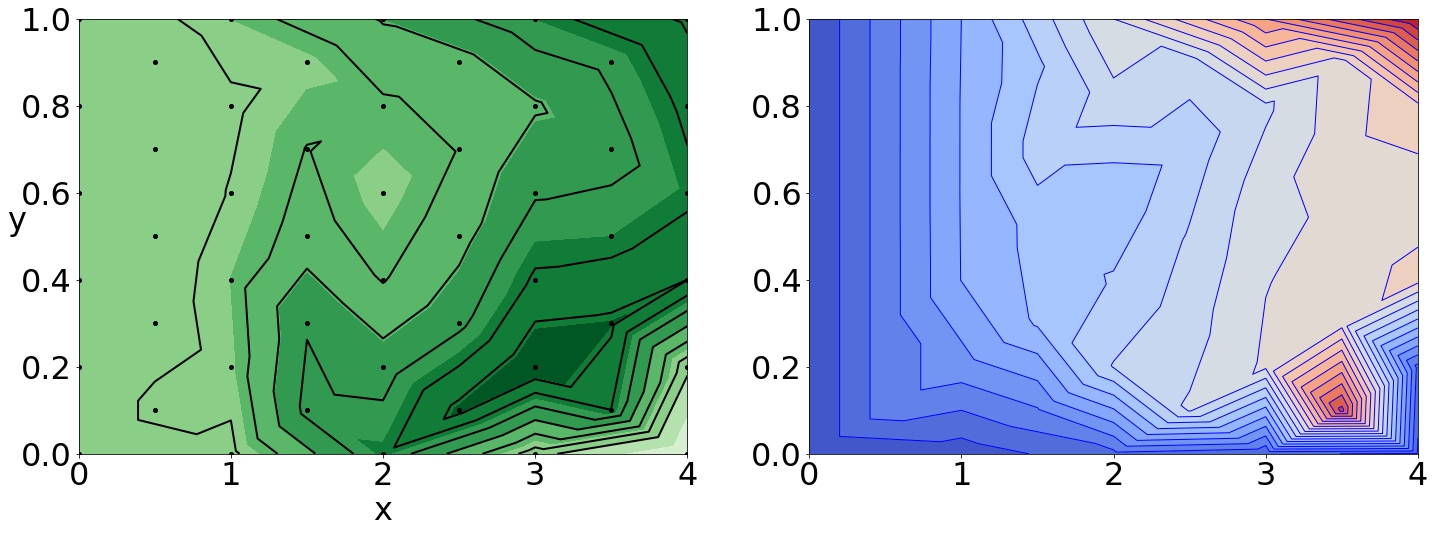

In [10]:
plt.rcParams.update({'font.size': 32})

cmap = plt.get_cmap('Greens')
cmap2=plt.cm.coolwarm
levels1 = np.linspace(0, 13, 21)
levels2 = np.linspace(0, 4, 21)

fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(24, 8))

plt1.plot(X, Y, '.k', markersize=8)
plt1.tricontourf(X, Y, T, cmap=cmap, zorder=1) # extent=[x0, y0, x1, y1],
plt1.tricontour(X, Y, T, colors='k', linewidths=2, levels=levels1)
# plt1.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)

plt1.set_xlabel("x", fontsize=32)
h1=plt1.set_ylabel("y", fontsize=32)
h1.set_rotation(0)
plt.savefig('Tviz')

plt2.tricontourf(X, Y, S, cmap=cmap2 , zorder=1, levels=levels2)
plt2.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)

## Explicit representation of contour lines.


In order to obtain the position $\bar{P}$
on the line $\overline{P_1 P_2}$ we assume that the parameter $\alpha$
in the linear interpolation
\begin{align*}
    \bar{P} = \alpha P_2 + (1-\alpha) P_1
\end{align*}
is equivalent tothe parameter $\alpha$ in
\begin{align*}
    \bar{T} = \alpha T_2 + (1-\alpha) T_1,
\end{align*}
which can be identified as
\begin{align*}
    \alpha = \frac{\bar{T}-T_1}{T_2 - T_1}
\end{align*}



In [11]:
def getContour(q_T):
    j=0
    C_list = []
    for eh in mesh.edges():
        j=j+1
        # print(eh.idx())
        heh = mesh.halfedge_handle(eh, 0)
        vh1 = mesh.from_vertex_handle(heh)
        vh2 = mesh.to_vertex_handle(heh)    

        k1 = vh1.idx()
        k2 = vh2.idx()
        if (T[k1] - median_T)*(T[k2] - q_T) < 0:
            # print(eh.idx(),':', vh1.idx(), vh2.idx())    
            alpha = (median_T - T[k1])/(T[k2] - T[k1])
            Vm = (alpha*V[k1,0:2]+(1-alpha)*V[k2,0:2])
            C_list.append(Vm)

    C_list = np.array(C_list)
    I=np.argsort(C_list[:,0])
    C_sort=C_list[I,:]
    return C_sort
    
#  128 : 9 14

median_T = np.median(T)
quintiles = np.percentile(T, [20,40,60,80])
XY = getContour(quintiles[2])
plt.xlim(0, 5)
plt.ylim(0, 1)

plt.plot(XY[:,0], XY[:,1], '.-k', markersize=2)
plt.plot(XY[:,0], XY[:,1], 'ob', markersize=8)    

    